In [45]:
import pandas as pd
import numpy as np

In [46]:
# SELECT BLCK_CD, TS_YMD, SUM(AMT_CORR)
# FROM TB_SHCARD_LOCAL_BLCK_DAY_TIME
# WHERE SB_UPJONG_CD IN ('SB001','SB002','SB003','SB004','SB005','SB006','SB007')
# GROUP BY BLCK_CD, TS_YMD

#한식/ 일식 / 양식 / 중식 / 제과점 / 커피 / 패스트푸드

In [47]:
all_sales = pd.read_csv('all_sales.csv')

In [48]:
# BLCK_CD가 없는 부분은 버림 (17개 행) + 19년부터
sales1920 = all_sales.query('TS_YMD > 20181231').dropna()

In [49]:
sales1920.isna().sum()

BLCK_CD          0
TS_YMD           0
SUM(AMT_CORR)    0
dtype: int64

# 매출 데이터에 동 붙이고, 동별 합계

In [53]:
code = pd.read_csv('TBGIS_BLCK_RELM_INFO.csv', encoding='cp949')
code = code.iloc[:,:2]
code.columns = ["블록코드", "동"]
code["동"] = code["동"].map(lambda x : x.split("-")[0])

In [55]:
living = pd.read_csv('생활인구수+점포수.csv', encoding='cp949', index_col=[0])
living['동'] = living['동'].apply(lambda x: x.replace("제", ""))
living['동'] = living['동'].apply(lambda x: x.replace("홍1동", "홍제1동"))
living['동'] = living['동'].apply(lambda x: x.replace("홍2동", "홍제2동"))
living['동'] = living['동'].apply(lambda x: x.replace("홍3동", "홍제3동"))
living['동'] = living['동'].apply(lambda x: x.replace("기동", "제기동"))
living['동'] = living['동'].apply(lambda x: x.replace("회제기동", "회기동"))

In [56]:
def nans(df):
    return df[df.isnull().any(axis=1)]

In [57]:
#code 에 있는 동이랑 living에 있는 동이랑차이 없는지
comp1 = pd.DataFrame(code['동'])
comp2 = pd.DataFrame(living['동'].unique(), columns = ["동"])
comp = comp1.merge(comp2, left_on = "동",right_on = "동", how="outer" )
nans(comp)

,동


In [58]:
sales1920_dong = sales1920.merge(code, left_on="BLCK_CD", right_on="블록코드", how="left")

sales1920_dong.drop(["BLCK_CD","블록코드"], axis=1, inplace=True)

daily_dong_sales1920 = sales1920_dong.groupby(["TS_YMD", "동"]).sum()

daily_dong_sales1920.columns = ["동_매출합계"]

In [59]:
daily_dong_sales1920.to_csv('동_매출_1920.csv')
daily_dong_sales1920 = pd.read_csv('동_매출_1920.csv')

# 매출 19년과 20년으로 나누기

In [60]:
daily_dong_sales1920 = pd.read_csv('동_매출_1920.csv')

dds19=daily_dong_sales1920.query("TS_YMD <= 20190831")

dds20=daily_dong_sales1920.query("TS_YMD>= 20200101")

# Paired T -Test

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
before = dds19[['동_매출합계']]
after = dds20[['동_매출합계']]
before.columns = ['dong_sales']
after.columns = ['dong_sales']

before['when'] = "pre_covid"
after["when"] = "covid"
data = before.append(after)
# 단위: 천만원
data['dong_sales'] =data['dong_sales'].apply(lambda x : x/10000000)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


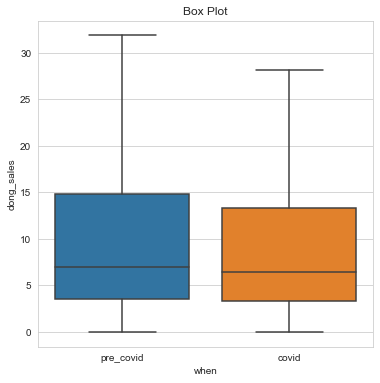

In [63]:
# showfliers false로 아웃라이어 배제하고 그려봄
sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
sns.boxplot(x="when", y='dong_sales', data= data, showfliers=False)
plt.title("Box Plot")
plt.show()

## T-Test


In [64]:
# 19년 1-8월 일별 평균 매출
dds19_ave = dds19.drop("TS_YMD", axis=1).groupby('동').mean()
# 20년 1-8월 일별 평균 매출
dds20_ave = dds20.drop("TS_YMD", axis=1).groupby('동').mean()

before = dds19_ave[['동_매출합계']]
after = dds20_ave[['동_매출합계']]

data = before.merge(after, on = "동", how="left")
data.columns = ['동_매출합계_2019','동_매출합계_2020' ]

data.to_csv('동_매출합계,20192020.csv')
data = pd.read_csv('동_매출합계,20192020.csv')

a = data.iloc[:,1]
b = data.iloc[:,2]


In [65]:
import scipy.stats
import numpy as np

In [66]:
m =scipy.stats.ttest_rel(a,b)

t = m.statistic
df = len(a) + len(b) -2
cohend = abs(t)/np.sqrt(df)

t2 = t**2
pearr = np.sqrt(t2/(t2+df))

In [68]:
scipy.stats.ttest_rel(a,b)

Ttest_relResult(statistic=8.16960842375462, pvalue=3.6319321057928055e-15)

In [67]:
print(f"2019년 지역별 일별 매출 평균 {a.mean()} | 2020년 지역별 일별 매출 평균 {b.mean()}")
print('-'*100)
print(f"Paired T Test의 결과는 pvalue 값이 {m.pvalue}")
print(f"2020년 매출 평균이 통계적으로 유의미하게 낮음을 확인할 수 있다")
print(f"효과크기는 낮은 수준으로, Cohen's d = {cohend} | r = {pearr}")

2019년 지역별 일별 매출 평균 141136678.74791312 | 2020년 지역별 일별 매출 평균 125666223.18095952
----------------------------------------------------------------------------------------------------
Paired T Test의 결과는 pvalue 값이 3.6319321057928055e-15
2020년 매출 평균이 통계적으로 유의미하게 낮음을 확인할 수 있다
효과크기는 낮은 수준으로, Cohen's d = 0.281209519040364 | r = 0.2707094638665446


### 데이터 정규성 검정 pvalue가 0.05보다 커야

In [360]:
# 데이터 정규성 검정 pvalue가 0.05보다 커야하는데..
from scipy.stats import shapiro

before = dds19_ave[['동_매출합계']]
after = dds20_ave[['동_매출합계']]
data = before.merge(after, on = "동", how="left")
data.columns = ['동_매출합계_2019','동_매출합계_2020' ]
data['동_매출합계_2020/2019'] = (data['동_매출합계_2020'] - data['동_매출합계_2019'])/data['동_매출합계_2019']*100

shapiro(data['동_매출합계_2020/2019'])

(0.8837820291519165, 2.4935232179596686e-17)

In [370]:
# data['동_매출합계_2020/2019']

data_comp = data[['동_매출합계_2020/2019']]
data_comp.columns=['동_매출합계_비']

In [440]:
print(data_comp.query("동_매출합계_비 < 0").count())

동_매출합계_비    350
dtype: int64


In [377]:
data_comp.query("동_매출합계_비 > 0").count()

동_매출합계_비    73
dtype: int64

In [381]:
data_comp.query("동_매출합계_비 > 0").index

Index(['가락1동', '가양1동', '가회동', '개포2동', '고덕2동', '구로1동', '구의1동', '구의2동', '금호4가동',
       '내곡동', '답십리2동', '도봉1동', '독산1동', '동화동', '등촌1동', '마천1동', '망원1동', '망원2동',
       '면목3.8동', '면목4동', '면목본동', '목2동', '목3동', '문래동', '문정2동', '발산1동', '방배본동',
       '방학3동', '북가좌2동', '삼각산동', '상도4동', '상일동', '성수1가1동', '성수1가2동', '성수2가1동',
       '성수2가3동', '성현동', '세곡동', '송정동', '송파1동', '수유1동', '수유2동', '시흥3동', '신길3동',
       '신길7동', '신당동', '신사1동', '신월1동', '신월6동', '쌍문3동', '암사1동', '양평2동', '왕십리2동',
       '용문동', '우이동', '월계3동', '위례동', '응암2동', '응암3동', '이촌2동', '자양2동', '장위1동',
       '장지동', '중계4동', '중곡1동', '중곡4동', '중화1동', '진관동', '창2동', '창4동', '홍제2동',
       '화곡본동', '휘경2동'],
      dtype='object', name='동')

In [382]:
data_comp.query("동_매출합계_비 < 0").index

Index(['가락2동', '가락본동', '가리봉동', '가산동', '가양2동', '가양3동', '갈현1동', '갈현2동', '강일동',
       '개봉1동',
       ...
       '화곡6동', '화곡8동', '화양동', '황학동', '회기동', '회현동', '효창동', '후암동', '휘경1동',
       '흑석동'],
      dtype='object', name='동', length=350)

In [385]:
data_comp.index

Index(['가락1동', '가락2동', '가락본동', '가리봉동', '가산동', '가양1동', '가양2동', '가양3동', '가회동',
       '갈현1동',
       ...
       '화곡본동', '화양동', '황학동', '회기동', '회현동', '효창동', '후암동', '휘경1동', '휘경2동',
       '흑석동'],
      dtype='object', name='동', length=423)

# 핫비핫 선정 - 2019 매출 기준

In [69]:
daily_dong_sales1920 = pd.read_csv('동_매출_1920.csv')

dds19=daily_dong_sales1920.query("TS_YMD <= 20190831")

dds20=daily_dong_sales1920.query("TS_YMD>= 20200101")

In [70]:
# 평균 일 매출로 상하위 10개

dds19 = dds19.groupby("동")["동_매출합계"].mean().to_frame().sort_values(by="동_매출합계", ascending=False).reset_index()

In [71]:
# dds19[:10]
# dds19[-10:]

In [72]:
a = list(dds19[:10]["동"])
b = list(dds19[-10:]["동"])
print(f"평균 일 매출이 상위 10개 동은 :{a}")
# 삼성동
print(f"평균 일 매출이 하위 10개 동은 :{b}")

평균 일 매출이 상위 10개 동은 :['역삼1동', '여의동', '종로1.2.3.4가동', '서교동', '명동', '서초3동', '청담동', '압구정동', '가양1동', '논현2동']
평균 일 매출이 하위 10개 동은 :['삼성동', '시흥2동', '신길4동', '응암2동', '돈암2동', '창신3동', '이촌2동', '잠실7동', '개포1동', '둔촌1동']


In [73]:
daily_dong_sales1920 = daily_dong_sales1920.loc[daily_dong_sales1920["동"].isin(dds19[:10].append(dds19[-10:])["동"])].reset_index().drop("index", axis=1)

In [74]:
# 상하위 열개동 
daily_dong_sales1920.to_csv("1029_0928_매출상하위10개.csv")

# living 기준으로 다른거 붙이기 (지하철, 코로나)
### 동이름 변경한거 동일하게 적용해야

In [297]:
teul = living.iloc[:,:6]


In [ ]:
['역삼1동', '여의동', '종로1.2.3.4가동', '서교동', '명동', '서초3동', '청담동', '압구정동', '가양1동', '논현2동']
강남구, 영등포구, 종로구, 마포구, 중구, 서초구, 강남구, 강남구, 강서구, 강남구
['삼성동', '시흥2동', '신길4동', '응암2동', '돈암2동', '창신3동', '이촌2동', '잠실7동', '개포1동', '둔촌1동']
관악구, 금천구, 영등포, 은평구, 성북구, 종로구, 용산구, 송파구, 강남구, 강동구

In [298]:
teul["월"] = teul["날짜"].map(lambda x : str(x)[:-2])
teul["월"] = teul["월"].map(lambda x : int(x))


In [299]:
teul = teul.loc[teul["동"].isin(dds19[:10].append(dds19[-10:])["동"])]
teul.shape

(486, 7)

In [300]:
subway = pd.read_csv('지하철_승하차승객_및_구정보.csv', encoding='cp949')

In [301]:
subway_gu= subway.groupby(['사용월','구'])['총승하차승객수'].sum().to_frame()

In [302]:
subway_gu =subway_gu.reset_index()

In [303]:
# 구별 유동인구 합 일별
subway_gu.columns = ['월', '구', '구별_유동인구']
subway_gu = subway_gu.query('월 >= 202002')


In [83]:
teuled = teul.merge(subway_gu, how="inner")
teuled.shape

(4860, 8)

In [304]:
corona = pd.read_csv("코로나_재정리.csv",encoding = 'cp949')


In [306]:
corona = corona[corona.날짜 >='2020-02-01']


In [305]:
corona = corona[corona.날짜 <'2020-10-01']
corona.tail()

,날짜,구,구신규,전국신규,서울신규,동
34541,2020-09-30,중랑구,1,113.0,30,묵2동
34542,2020-09-30,중랑구,1,113.0,30,망우본동
34543,2020-09-30,중랑구,1,113.0,30,망우3동
34544,2020-09-30,중랑구,1,113.0,30,신내1동
34545,2020-09-30,중랑구,1,113.0,30,신내2동


In [87]:
corona.isnull().sum()

날짜        0
구         0
구신규       0
전국신규      1
서울신규      0
동       142
dtype: int64

In [307]:
corona["날짜"] = corona["날짜"].map(lambda x : str(x).replace("-",""))
corona["날짜"] = corona["날짜"].map(lambda x : int(x))


In [89]:
corona = corona.drop_duplicates(subset=['날짜', '구', '구신규', '전국신규', '서울신규']).drop("동",axis=1)

In [90]:
res = pd.merge(teuled, corona[['날짜','구', '구신규']], how = "left")
res.shape


(4860, 9)

In [91]:
corona = corona.drop_duplicates(subset=['날짜', '전국신규', '서울신규']).drop(["구", "구신규"],axis=1)

In [92]:
res = res.merge(corona[['날짜', '전국신규','서울신규']], how = "left")
res.shape

(4860, 11)

In [93]:
res = res.fillna(0)
res.shape

(4860, 11)

In [308]:
stores = pd.read_csv('자동화_점포수분기총.csv')

In [309]:
stores.drop(['Unnamed: 0', 'Unnamed: 0.1', '생활밀접업종'],axis=1, inplace=True)

In [310]:
stores_1 =stores[['행정구역','2020년 1분기전체점포수', '2020년 1분기프랜차이즈점포수', '2020년 1분기일반점포수']]
stores_2 =stores[['행정구역','2020년 2분기전체점포수', '2020년 2분기프랜차이즈점포수', '2020년 2분기일반점포수']]
stores_1 = stores_1.assign(분기 = "1분기")
stores_2 = stores_2.assign(분기 = "2분기")


In [97]:
stores_1.columns

Index(['행정구역', '2020년 1분기전체점포수', '2020년 1분기프랜차이즈점포수', '2020년 1분기일반점포수', '분기'], dtype='object')

In [98]:
trial = res.merge(stores_1, left_on = ['동', '분기'], right_on = ['행정구역', '분기'], how="left")

In [99]:
trial = trial.merge(stores_2, left_on = ['동', '분기'], right_on = ['행정구역', '분기'], how="left")

In [100]:
trial['동_전체음식점수'] = trial['2020년 1분기전체점포수'].combine_first(trial['2020년 2분기전체점포수'])
trial['동_프랜차이즈음식점수'] = trial['2020년 1분기프랜차이즈점포수'].combine_first(trial['2020년 2분기프랜차이즈점포수'])
trial['동_일반음식점수'] = trial['2020년 1분기일반점포수'].combine_first(trial['2020년 2분기일반점포수'])

In [101]:
trial = trial.fillna(0)

In [102]:
trial.shape

(4860, 22)

## 매출과 trial 합치기

In [103]:
daily_dong_sales1920 = pd.read_csv('동_매출_1920.csv')

dds20=daily_dong_sales1920.query("TS_YMD>= 20200101")

In [104]:
trial = trial.merge(dds20, left_on=["날짜", "동"], right_on = ["TS_YMD", "동"], how="left")

In [105]:

trial.to_csv('1029_1037_20개동매출까지다해썽.csv')

# 회귀분석

### 분석 세팅을 합니다

In [106]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols


In [107]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns    

In [108]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family="gulim")

In [336]:
daily_dong_sales1920 = pd.read_csv('동_매출_1920.csv')
dds19=daily_dong_sales1920.query("TS_YMD <= 20190831")
dds19 = dds19.groupby("동")["동_매출합계"].mean().to_frame().sort_values(by="동_매출합계", ascending=False).reset_index()
# a = list(dds19[:10]["동"])
# b = list(dds19[-10:]["동"])

In [337]:
dongs20 = dds19[:10].assign(핫비핫 = '핫플').append(dds19[-10:].assign(핫비핫 = '비핫플'))


In [113]:

vars= pd.read_csv('1029_1037_20개동매출까지다해썽.csv')
# 불안하니까 한번더 걸러보자..
vars = vars.query("월 <202009 & 월 >202000")
vars = vars.query("시도명 =='서울특별시'")
vars.drop(['분기','시도명',  "Unnamed: 0", '행정구역_x','행정구역_y',
       '2020년 1분기전체점포수', '2020년 1분기프랜차이즈점포수', '2020년 1분기일반점포수',
       '2020년 2분기전체점포수', '2020년 2분기프랜차이즈점포수', '2020년 2분기일반점포수','TS_YMD'],axis=1, inplace=True)
vars = vars.fillna(0)

In [115]:
# 점포 당 매출로 바꾸기
vars["동_음식점평균결제액"] = vars['동_매출합계'] / vars['동_전체음식점수']
vars.drop("동_매출합계", axis=1, inplace=True)

## 상관관계

In [116]:
vars = vars[['날짜', '월',  '구', '동','동_음식점평균결제액','생활인구수', '구별_유동인구',  '동_전체음식점수',
       '동_프랜차이즈음식점수', '동_일반음식점수','구신규', '전국신규', '서울신규']]

In [117]:
vars.columns = ['날짜', '월', '구', '동','동_점포당평균결제액', '동_생활인구', '구_유동인구', '동_전체음식점수', '동_프랜차이즈음식점수',
       '동_일반음식점수', '구_신규', '전국_신규', '서울_신규']

In [118]:
vars = vars.merge(dongs20[["동", "핫비핫"]], how="left")


In [120]:
var_fc = vars
var_fc["핫비핫"] = var_fc["핫비핫"].apply(lambda x: x.replace("비핫플","0"))
var_fc["핫비핫"] = var_fc["핫비핫"].apply(lambda x: x.replace("핫플","1"))
var_fc["핫비핫"] = var_fc["핫비핫"].apply(int)

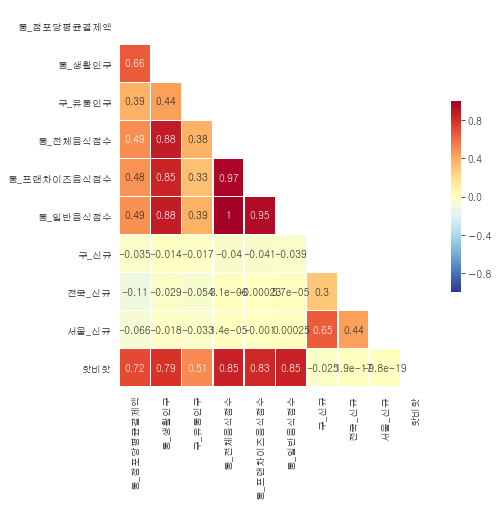

In [122]:
correlation = var_fc.drop(['날짜', '월'],axis=1).corr()
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(7,7) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(correlation, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()


<div class = "alert alert-block alert-success">

우선 일반점포수 + 프랜차이즈 점포수 = 전체 점포수이기 때문에 높은 상관을 보이는 것입니다.


</div>

## VIF 확인

<div class = "alert alert-block alert-warning">
회귀분석을 하기 전에, 진정한 독립변수를 골라봐야 합니다. 
변수가 "독립"이어야 결과값을 통해 종속변수에 대한 변수의 영향력을 볼 수 있습니다. 그렇지만 변수끼리 이미 영향을 주고 있다면, 특정 변수의 영향을 제대로 뽑아볼 수 없습니다. 그렇기 때문에 VIF를 확인해서, VIF 10 이상인 (아니면 Tolerance 0.1이하인) 변수 중 선택적으로 제거하여야 합니다.  
<br>
VIF를 확인하고, 회귀분석에 사용할 변수를 우선적으로 솎아내는 과정이라고 할 수 있습니다.
</div>

In [123]:
import statsmodels.formula.api as smf

def get_vif(exogs, data):


    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # create formula for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        formula = f"{exog} ~ {' + '.join(not_exog)}"

        # extract r-squared from the fit
        r_squared = smf.ols(formula, data=data).fit().rsquared

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

<div class = "alert alert-block alert-warning">
<b>설명:</b> <br>
일반 점포수와 전체 점포수의 상관관계가 매우 높았습니다. 전체점포수 = 프랜차이즈 + 일반 점포수이기 때문입니다. <br>
따라서 전체, 프랜차이즈, 일반 점포수 모두를 독립변수로 사용하면 VIF값이 무한대로 나오기 때문에, 미리 전체 점포수를 제거했습니다.
</div>

In [124]:
var_fc.columns

Index(['날짜', '월', '구', '동', '동_점포당평균결제액', '동_생활인구', '구_유동인구', '동_전체음식점수',
       '동_프랜차이즈음식점수', '동_일반음식점수', '구_신규', '전국_신규', '서울_신규', '핫비핫'],
      dtype='object')

In [380]:
# # # 일반 제거
# exogs = [ '동_생활인구', '구_유동인구', '동_전체음식점수',
#        '동_프랜차이즈음식점수', '구_신규', '전국_신규', '서울_신규', '핫비핫']
# get_vif(exogs, var_fc)

# # # 프차 제거
# exogs = [ '동_생활인구', '구_유동인구', '동_전체음식점수',
#        '동_일반음식점수', '구_신규', '전국_신규', '서울_신규', '핫비핫']
# get_vif(exogs, var_fc)

# # 전체 제거
# exogs = [ '동_생활인구', '구_유동인구', 
#        '동_프랜차이즈음식점수', '동_일반음식점수', '구_신규', '전국_신규', '서울_신규', '핫비핫']
# get_vif(exogs, var_fc)

# # 전체제거하고 프차제거
# exogs = [ '동_생활인구', '구_유동인구', 
#         '동_일반음식점수', '구_신규', '전국_신규', '서울_신규', '핫비핫']
# get_vif(exogs, var_fc)

In [125]:
# 전체제거하고 일반제거
exogs = [ '동_생활인구', '구_유동인구', 
       '동_프랜차이즈음식점수',  '구_신규', '전국_신규', '서울_신규', '핫비핫']
get_vif(exogs, var_fc)

,VIF,Tolerance
구_신규,1.748146,0.572035
구_유동인구,1.477186,0.676963
동_생활인구,4.045967,0.247160
동_프랜차이즈음식점수,5.197012,0.192418
서울_신규,1.961000,0.509944
전국_신규,1.246925,0.801973
핫비핫,4.240899,0.235799


## 회귀분석

동_생활인구+구_유동인구+동_프랜차이즈음식점수+구_신규+전국_신규+서울_신규+핫비핫

In [126]:
vars['핫비핫'] = vars['핫비핫'].apply(str)
vars['핫비핫'] = vars['핫비핫'].apply(lambda x : x.replace("1", "핫플"))
vars['핫비핫'] = vars['핫비핫'].apply(lambda x : x.replace("0", "비핫플"))

In [127]:
vars.columns

Index(['날짜', '월', '구', '동', '동_점포당평균결제액', '동_생활인구', '구_유동인구', '동_전체음식점수',
       '동_프랜차이즈음식점수', '동_일반음식점수', '구_신규', '전국_신규', '서울_신규', '핫비핫'],
      dtype='object')

In [128]:
a = ols("동_점포당평균결제액 ~동_생활인구+구_유동인구+동_프랜차이즈음식점수+구_신규+전국_신규+서울_신규+핫비핫",data=vars).fit()
a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             동_점포당평균결제액   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     1267.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:00:45   Log-Likelihood:                -58914.
No. Observations:                4260   AIC:                         1.178e+05
Df Residuals:                    4252   BIC:                         1.179e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.274e+05   9185.506     24.760      0.000    2.09e+05    2.45e+05
핫비핫[T.핫플]    8.085e+05   1.55e+04     52.164      0.000    7.78e+05    8.39e+05
동_생활인구          9.4277      0.254     37.179      0.000       8.931       9.925
구_유동인구         -0.0057      0.001    -10.557      0.000      -0.007      -0.005
동_프랜차이즈음식점수 -2418.5438     59.138    -40.897      0.000   -2534.485   -2302.603
구_신규          682.5124   2656.338      0.257      0.797   -4525.297    5890.322
전국_신규        -291.4096     31.193     -9.342      0.000    -352.565    -230.254
서울_신규        -260.1466    154.574     -1.683      0.092    -563.193      42.900
==============================================================================
Omnibus:                     1818.591   Durbin-Watson:                   0.608
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34896.697
Skew:                           1.554   Prob(JB):                         0.00
Kurtosis:                      16.673   Cond. No.                     7.79e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.79e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [410]:
b = ols("동_점포당평균결제액 ~동_생활인구+구_유동인구+동_프랜차이즈음식점수+구_신규+전국_신규+서울_신규+핫비핫+구_신규:핫비핫+전국_신규:핫비핫+서울_신규:핫비핫",data=vars).fit()
b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             동_점포당평균결제액   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     910.8
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:35:22   Log-Likelihood:                -58875.
No. Observations:                4260   AIC:                         1.178e+05
Df Residuals:                    4249   BIC:                         1.178e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.061e+05   9466.168     21.777      0.000    1.88e+05    2.25e+05
핫비핫[T.핫플]        8.577e+05   1.65e+04     52.065      0.000    8.25e+05     8.9e+05
동_생활인구              9.3163      0.252     36.942      0.000       8.822       9.811
구_유동인구             -0.0057      0.001    -10.684      0.000      -0.007      -0.005
동_프랜차이즈음식점수     -2408.4447     58.864    -40.915      0.000   -2523.850   -2293.040
구_신규             1380.5012   3233.368      0.427      0.669   -4958.588    7719.591
구_신규:핫비핫[T.핫플]  -4988.4547   5673.931     -0.879      0.379   -1.61e+04    6135.414
전국_신규             -49.1644     43.645     -1.126      0.260    -134.732      36.403
전국_신규:핫비핫[T.핫플]  -483.3468     61.848     -7.815      0.000    -604.601    -362.092
서울_신규            -276.3251    219.123     -1.261      0.207    -705.920     153.270
서울_신규:핫비핫[T.핫플]   124.4457    309.023      0.403      0.687    -481.400     730.292
==============================================================================
Omnibus:                     1856.952   Durbin-Watson:                   0.620
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38837.626
Skew:                           1.573   Prob(JB):                         0.00
Kurtosis:                      17.454   Cond. No.                     8.30e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.3e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [414]:
c = ols("동_점포당평균결제액 ~동_생활인구+구_유동인구+동_프랜차이즈음식점수+구_신규+전국_신규+서울_신규+핫비핫+구_신규:핫비핫+전국_신규:핫비핫",data=vars).fit()
c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             동_점포당평균결제액   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     1012.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:46:06   Log-Likelihood:                -58875.
No. Observations:                4260   AIC:                         1.178e+05
Df Residuals:                    4250   BIC:                         1.178e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.058e+05   9435.498     21.816      0.000    1.87e+05    2.24e+05
핫비핫[T.핫플]        8.581e+05   1.64e+04     52.225      0.000    8.26e+05     8.9e+05
동_생활인구              9.3128      0.252     36.954      0.000       8.819       9.807
구_유동인구             -0.0057      0.001    -10.683      0.000      -0.007      -0.005
동_프랜차이즈음식점수     -2407.3753     58.799    -40.943      0.000   -2522.651   -2292.099
구_신규              812.4188   2909.130      0.279      0.780   -4890.996    6515.833
구_신규:핫비핫[T.핫플]  -3608.6247   4522.095     -0.798      0.425   -1.25e+04    5257.043
전국_신규             -53.4912     42.298     -1.265      0.206    -136.417      29.435
전국_신규:핫비핫[T.핫플]  -475.2111     58.450     -8.130      0.000    -589.803    -360.619
서울_신규            -213.8382    154.704     -1.382      0.167    -517.138      89.462
==============================================================================
Omnibus:                     1857.942   Durbin-Watson:                   0.619
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38885.150
Skew:                           1.574   Prob(JB):                         0.00
Kurtosis:                      17.462   Cond. No.                     8.29e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.29e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 시각화

In [314]:
# 핫비핫 점포당 평균 일 결제액
k = vars.groupby(['월', '핫비핫'])['동_점포당평균결제액'].mean().to_frame().reset_index()
k["월"] = k["월"].apply(str)
k = k.pivot("월", "핫비핫", "동_점포당평균결제액")

In [317]:
k = k.pivot("월", "핫비핫", "동_점포당평균결제액")

In [318]:
k

핫비핫,비핫플,핫플
월,,
202002,224792.611247,859772.088447
202003,212724.940099,694933.579386
202004,222005.190304,832903.366889
202005,283789.745457,941193.174441
202006,239018.744661,872663.164534
202007,207831.592890,958962.040874
202008,200835.365853,757142.430265


In [ ]:
# 핫비핫 점포당 평균 일 결제액
k = vars.groupby(['월', '핫비핫'])['동_점포당평균결제액'].mean().to_frame().reset_index()
k["월"] = k["월"].apply(str)
k = k.pivot("월", "핫비핫", "동_점포당평균결제액")

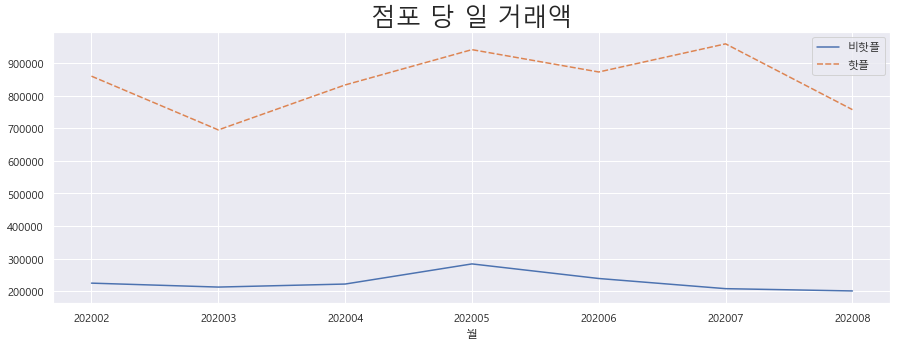

In [445]:
sns.set(font="Malgun Gothic", rc = {"axes.unicode_minus" : False, "figure.figsize":(15,5) }, style = "darkgrid")

plt.title(label="점포 당 일 거래액",fontsize=25)
d = sns.lineplot(data = k)
for p in d.patches:
    left, bottom, width, height = p.get_bbbox().bounds
    plt.annotate("%.f"(height),(left+width/2, height*1.01), ha='center')

In [7]:
daily_dong_sales1920 = pd.read_csv('동_매출_1920.csv')
dds19=daily_dong_sales1920.query("TS_YMD <= 20190831")
dds20=daily_dong_sales1920.query("TS_YMD >= 20200831")
dds19 = dds19.groupby("동")["동_매출합계"].mean().to_frame().reset_index()
dds20 = dds20.groupby("동")["동_매출합계"].mean().to_frame().reset_index()

In [8]:
dds19.columns=['동','2019_동_매출합계']
dds20.columns=['동','2020_동_매출합계']

In [9]:
dds = dds19.merge(dds20, how='left')

In [10]:
dds = dds.assign(매출_2019_대비_2020 = dds['2020_동_매출합계'] / dds['2019_동_매출합계'])
dds = dds[['동', '매출_2019_대비_2020']]


In [11]:
dds.query('매출_2019_대비_2020 < 0.3')

,동,매출_2019_대비_2020
318,이태원1동,0.202393


In [12]:
dds.query('매출_2019_대비_2020 < 0.4')

,동,매출_2019_대비_2020
15,개포1동,0.376491
56,노량진2동,0.391671
60,능동,0.396207
86,돈암1동,0.385980
87,돈암2동,0.337302
131,방배2동,0.318150
149,부암동,0.384934
186,서강동,0.399727
187,서교동,0.322560
211,송중동,0.393381


In [16]:
list(dds.query('매출_2019_대비_2020 < 0.4')["동"])

['개포1동',
 '노량진2동',
 '능동',
 '돈암1동',
 '돈암2동',
 '방배2동',
 '부암동',
 '서강동',
 '서교동',
 '송중동',
 '신촌동',
 '연남동',
 '이태원1동']

In [13]:
dds.query('매출_2019_대비_2020 < 0.5')

,동,매출_2019_대비_2020
9,갈현1동,0.473051
15,개포1동,0.376491
41,금호1가동,0.427646
53,남현동,0.427577
55,노량진1동,0.409579
56,노량진2동,0.391671
58,논현1동,0.481598
60,능동,0.396207
61,다산동,0.497085
75,대흥동,0.496951


In [15]:
list(dds.query('매출_2019_대비_2020 < 0.5')["동"])

['갈현1동',
 '개포1동',
 '금호1가동',
 '남현동',
 '노량진1동',
 '노량진2동',
 '논현1동',
 '능동',
 '다산동',
 '대흥동',
 '독산4동',
 '돈암1동',
 '돈암2동',
 '동선동',
 '등촌3동',
 '반포3동',
 '반포본동',
 '방배2동',
 '부암동',
 '사근동',
 '사당1동',
 '사당2동',
 '상계2동',
 '서강동',
 '서교동',
 '서원동',
 '서초4동',
 '석관동',
 '성북동',
 '송중동',
 '신림동',
 '신촌동',
 '연남동',
 '영등포동',
 '오륜동',
 '왕십리도선동',
 '용산2가동',
 '월곡1동',
 '이태원1동',
 '이태원2동',
 '자양4동',
 '장위2동',
 '전농1동',
 '중림동',
 '창신2동',
 '혜화동',
 '화양동',
 '휘경1동']

In [18]:
# daily_dong_sales1920 = pd.read_csv('동_매출_1920.csv')
# dds19=daily_dong_sales1920.query("TS_YMD <= 20190831")
# dds20=daily_dong_sales1920.query("TS_YMD >= 20200831")
# dds19 = dds19.groupby("동")["동_매출합계"].mean().to_frame().reset_index()
# dds20 = dds20.groupby("동")["동_매출합계"].mean().to_frame().reset_index()
# dds19.columns=['동','2019_동_매출합계']
# dds20.columns=['동','2020_동_매출합계']
# dds = dds19.merge(dds20, how='left')
# dds = dds.assign(매출_2019_대비_2020 = dds['2020_동_매출합계'] / dds['2019_동_매출합계'])




In [247]:
daily_dong_sales1920 = pd.read_csv('동_매출_1920.csv')
dds19=daily_dong_sales1920.query("TS_YMD <= 20190831")
dds20=daily_dong_sales1920.query("TS_YMD >= 20200101")

In [248]:
dds19 = dds19.groupby(["동", "TS_YMD"])["동_매출합계"].mean().to_frame().reset_index()
dds20 = dds20.groupby(["동", "TS_YMD"])["동_매출합계"].mean().to_frame().reset_index()

In [293]:
def is_outlier(points, thresh=3.5):
    if len(points.shape) ==1:
        points = points[:,None]
    median = np.median(points,axis=0)
    diff = np.sum((points-median)**2, axis=1)
    diff = np.sqrt(diff)
    med_abs_dsviation = np.median(diff)
    modified_z = 0.6745 * diff / med_abs_dsviation
    return modified_z > thresh

In [233]:
# a = dds19["동_매출합계"] / 10000000
# a = a[~is_outlier(a)]



# b = dds20["동_매출합계"] / 10000000
# b = b[~is_outlier(b)]


# h1 = (a).to_frame().dropna().reset_index()
# h1.columns = ["아아", "2019_동_매출합계"]

# h2 = (b).to_frame().dropna().reset_index()
# h2.columns = ["아아아", "2020_동_매출합계"]

In [236]:
#  h =h1[["2019_동_매출합계"]].merge(h2[["2020_동_매출합계"]], how="left", left_index=True, right_index=True)

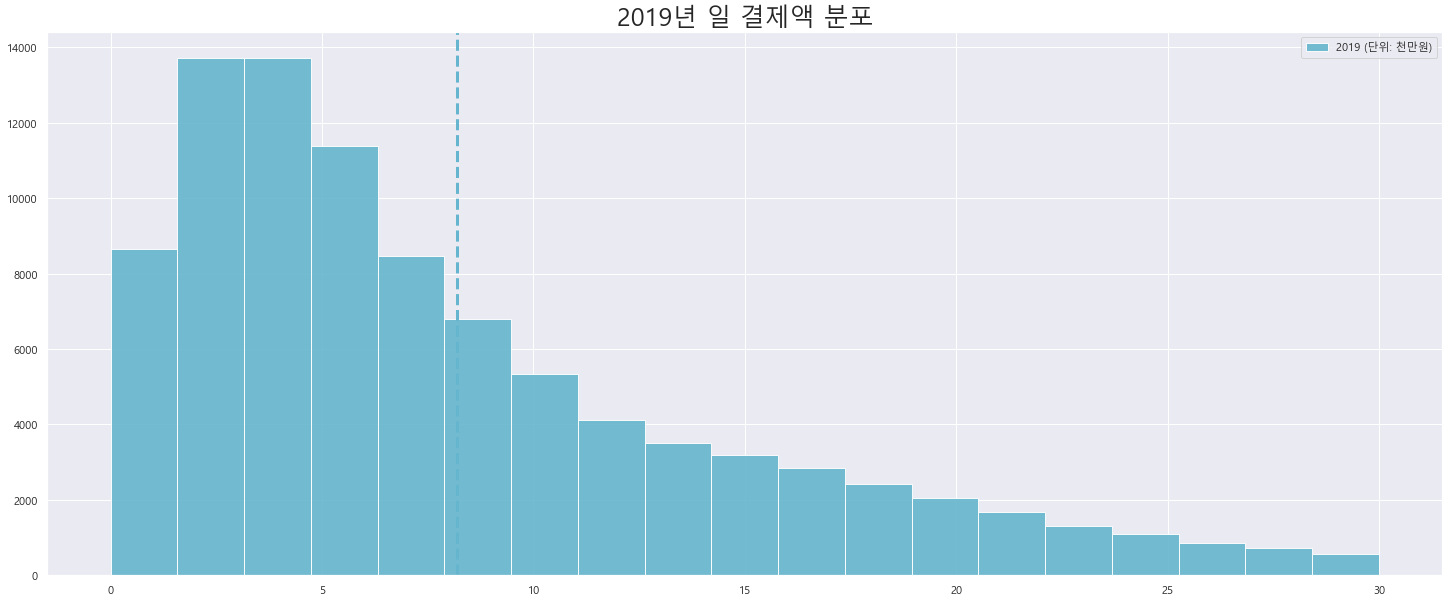

In [294]:
a = dds19["동_매출합계"] / 10000000
a = a[~is_outlier(a)]

sns.set(font="Malgun Gothic", rc = {"axes.unicode_minus" : False, "figure.figsize":(25,10) }, style = "darkgrid")

bins = np.linspace(0,30, 20)

plt.hist(a, bins,alpha=0.9, label="2019 (단위: 천만원)",color="c")
plt.axvline(a.mean(), color="c", linestyle="dashed", linewidth=3)
plt.title(label = "2019년 일 결제액 분포",fontsize=25)
plt.legend(loc='upper right')

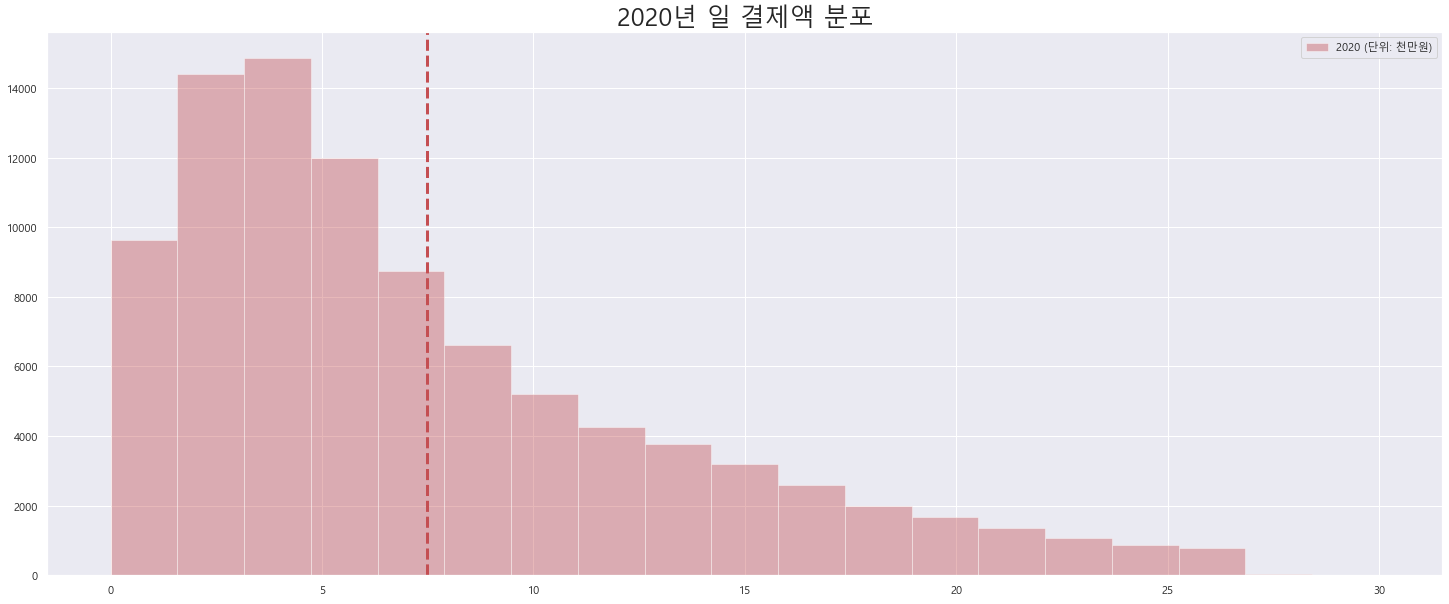

In [295]:
b = dds20["동_매출합계"] / 10000000
b = b[~is_outlier(b)]
sns.set({'figure.figsize':(25,10)})
bins = np.linspace(0,30, 20)

sns.set(font="Malgun Gothic", rc = {"axes.unicode_minus" : False, "figure.figsize":(25,10) }, style = "darkgrid")

plt.hist(b, bins,alpha=0.4, label="2020 (단위: 천만원)",color="r")
plt.axvline(b.mean(), color="r", linestyle="dashed", linewidth=3)
plt.title(label = "2020년 일 결제액 분포", fontsize=25)
plt.legend(loc='upper right')